# Final Project - Momentum + Mean Reversion Combo Strategy

## Brad Petersen

### Intro

I recently read an article about 'The 2 Most Powerful Forces in Markets' (see Link below) which were defined as Momentum and Mean Reversion.

So, I thought I'd try a combination strategy that invests both in stocks that seem to be 'on a run' and outperforming their historical averages (i.e. the 'momentum' stocks) and in those that seem to be underperforming lately and primed for a comeback (i.e. the 'mean reversion' stocks).  I've set up a bunch of variables that allow for future flexibility.  For example, you can change this program to look at the most recent annual, quarterly, monthly, or weekly returns and compare those to the corresponding historical average annual/quarterly/monthly/weekly returns to determine the momentum and mean reversion stocks.  Of course, using our backtesting function we developed, I've set it up to avoid hindsight bias and only trade on actionable (not-forward looking) data.  You can also vary the number of momentum and mean reversion stocks you want to invest in separately. Per usual, I've set some liquidity limits based on trading volume and price limits as well.  In class we used 1 or 2 dollars for price and around 100,000 dollars trading volume for our limits, but I found that to be particularly unsuccessful as I ran through interations of this strategy (I think because of the massive crashes of penny stocks).  So, I decided to go with limits of 20 dollars (price) and 1M dollars (volume)...this seems to have performed quite well, but was a random selection - there's certainly some possibilty to adjust these and perhaps impove the results.

One thing I was worried about in this strategy was getting caught up in "buying the hype" on the momentum side, leaving me susceptible to a 'pump and dump' or any other mania driven hype.  Additionally, I was worried about mean reversion stocks that recently have wildly underperformed their historical returns, suggesting that maybe something was incredibly and obviously wrong, that an automoated strategy inherently cannot recognize.  To (hopefully) account for that, when I select the most over- and under-performing stocks each period, this strategy intentionally avoids the stocks that are trading furthest from their averages by way of the tail() function in pandas.  For this submission, I cut off the 5 best performers and 10 worst performers.  Again, this was more or less decided randomly, and could certainly be optmized, but the result seems to be pretty acceptable.

I wanted to note that my backtest strategy starts in 2009, since the most recent PRICE data from my .csv files starts at 2009-04-15 and I didn't want to re-run the download functions to look back further.  But, since we've seen a boom (most of the last 10+ years) and a bust (COVID), hopefully, the data is fairly representative of long term performance.  If not, it would be rather easy to modify and look back futher.

Finally, someday I would like to evaluate this strategy to include trading on margin as well.  However, after evaluating the performance of my base set of assumptions (number of momentum/mean reversion stocks as well as how many to cut off, minimum price and volume, monthy rebalancing, etc.), the results (which you'll see below), suggested that the strategy was more volatile with a lower Sharpe Ratio (but with greater returns) than benchmarks and that maybe margin would be unwise.  Additionally, I'm not personally inclined to borrow on margin, as much as I want to, so I've held off for now.

Link:  https://compoundadvisors.com/2021/the-2-most-powerful-forces-in-markets#:~:text=Momentum%20and%20Mean%20Reversion.&text=Momentum%20dictates%20that%20what%20has,reverting%20back%20to%20its%20mean

Import standard libraries.

In [32]:
 # Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

import os

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Get Benchmark (VTI & SPY)

In [33]:
vti = tiingo.get_dataframe(['VTI'], '1900-1-1', metric_name='adjClose')
vti.index = pd.to_datetime(vti.index).tz_convert(None)

spy = tiingo.get_dataframe(['SPY'], '1900-1-1', metric_name='adjClose')
spy.index = pd.to_datetime(spy.index).tz_convert(None)

Check benchmark table...looks OK.  VTI NaN shouldn't be a problem

In [34]:
benchmark = spy.join(vti)
benchmark

,SPY,VTI
1993-01-29,25.877052,NaN
1993-02-01,26.061099,NaN
1993-02-02,26.116284,NaN
1993-02-03,26.392384,NaN
1993-02-04,26.502813,NaN
...,...,...
2021-05-10,417.940000,216.18
2021-05-11,414.210000,214.44
2021-05-12,405.410000,209.61
2021-05-13,410.280000,211.92


Check benchmark return table...looks OK.  VTI NaN shouldn't be a problem

In [35]:
benchmark.pct_change()

,SPY,VTI
1993-01-29,NaN,NaN
1993-02-01,0.007112,NaN
1993-02-02,0.002118,NaN
1993-02-03,0.010572,NaN
1993-02-04,0.004184,NaN
...,...,...
2021-05-10,-0.009902,-0.011749
2021-05-11,-0.008925,-0.008049
2021-05-12,-0.021245,-0.022524
2021-05-13,0.012013,0.011020


Get RATES to use compare_performance function...might not be necessary without leverage.

In [36]:
RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1']) / 100
RATES.columns = ['FedFunds','Treasury_1']
RATES

,FedFunds,Treasury_1
Date,,
1954-07-01,0.0080,NaN
1954-08-01,0.0122,NaN
1954-09-01,0.0107,NaN
1954-10-01,0.0085,NaN
1954-11-01,0.0083,NaN
...,...,...
2021-05-07,NaN,0.0005
2021-05-10,NaN,0.0005
2021-05-11,NaN,0.0005


Get stock price data.

In [37]:
PRICE  = pd.read_csv('data/tiingo/close.csv',    index_col='date', parse_dates=['date'])
RET    = pd.read_csv('data/tiingo/adjClose.csv', index_col='date', parse_dates=['date']).pct_change()  
VOLUME = pd.read_csv('data/tiingo/volume.csv',   index_col='date', parse_dates=['date'])
DOLLAR_VOLUME = VOLUME * PRICE

How many firms are we looking at here?

In [38]:
all_firms = PRICE.columns
all_firms

Index(['AIR', 'ABT', 'WDDD', 'ACU', 'AE', 'BKTI', 'AMD', 'AEM', 'APD', 'AKZOF',
       ...
       'KVSB', 'TIOAU', 'MSDAU', 'GGPIU', 'NECB', 'HITIF', 'AYRWF', 'OUTR',
       'ABCO', 'NHLDW'],
      dtype='object', length=8170)

Make sure we can limit trading to minimum price and minimum volume stocks (for liquidity) as done in class.  Looks OK.

In [39]:
MIN_P = 20
MIN_V = 1000000

p = PRICE        [all_firms].iloc[-1]
v = DOLLAR_VOLUME[all_firms].iloc[-1]
    
min_price  = p[p>MIN_P].index
min_volume = v[v>MIN_V].index
    
tradable_assets = min_price.intersection(min_volume) 
tradable_assets

Index(['AIR', 'ABT', 'ACU', 'AMD', 'AEM', 'APD', 'MATX', 'LNG', 'SWKS', 'HWM',
       ...
       'SHLS', 'MYTE', 'FERG', 'ALHC', 'CPNG', 'OLK', 'VZIO', 'BIGZ', 'KCAC',
       'AYRWF'],
      dtype='object', length=2473)

Look at tradable assets table.  OK.

In [40]:
RET[tradable_assets]

,AIR,ABT,ACU,AMD,AEM,APD,MATX,LNG,SWKS,HWM,...,SHLS,MYTE,FERG,ALHC,CPNG,OLK,VZIO,BIGZ,KCAC,AYRWF
date,,,,,,,,,,,,,,,,,,,,,
2009-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-16,0.042273,0.000703,0.022880,0.037791,-0.072790,0.011540,0.052812,-0.021654,0.012415,0.011050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,0.008644,0.028110,-0.052632,-0.002801,-0.045484,0.002811,0.059135,-0.006036,0.004459,0.012022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,-0.076467,0.004557,0.025000,-0.070225,0.076060,-0.047156,-0.105121,-0.056680,-0.025527,-0.097192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,0.046395,0.006351,0.001355,0.015106,-0.030658,0.004499,0.038726,0.034335,0.005695,0.039474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12,0.000734,0.001158,0.047941,-0.050507,-0.010696,-0.005205,-0.024553,-0.012582,-0.003232,0.002792,...,-0.027962,-0.002264,-0.004323,-0.013009,-0.013740,-0.015957,0.008018,-0.002683,-0.085646,-0.002034
2021-04-13,-0.016862,0.016276,0.001553,0.020489,0.018796,0.007883,-0.037477,0.004155,0.006219,-0.005569,...,0.004745,0.044251,-0.003474,0.011905,0.041575,0.049189,-0.007512,0.016143,0.009558,0.003036
2021-04-14,0.021129,-0.008617,-0.011468,-0.020451,-0.007347,-0.007822,-0.002760,0.017241,-0.007660,0.012757,...,0.004132,0.081130,-0.004832,0.036134,-0.029512,-0.008243,0.037400,0.006178,-0.033136,0.003055


As a proxy for monthly returns, I'm calculating the average daily price for each month, calculating the percent change (i.e. return) from one month to the next, and then averaging those returns over the period considered

This should be an acceptable proxy for monthly returns, removing any beginning/middle/end of month periodicity.  NOTE:  I'll make it more flexible later to run with Annualy, Quarterly, Monthly, or Weekly frequency.

In later functions, we'll include [:date] to remove the hindsight bias and make sure trading is based on actionable data, but for now, I'm just checking that the returned pandas.Series is usable.  Looks good.

In [41]:
PRICE[tradable_assets].resample('M').mean().pct_change().mean()

AIR      0.012866
ABT      0.009439
ACU      0.013127
AMD      0.032178
AEM      0.006191
           ...   
OLK      0.118472
VZIO     0.035023
BIGZ     0.092669
KCAC     0.419221
AYRWF    0.072924
Length: 2473, dtype: float64

This is calculating the most recent monthly return (difference between average monthly prices).  In the next cell, we'll use this to compare to historic averages.

Same note applies re:  A / Q / M / W frequency and [:date] concept as described above

In [42]:
PRICE[tradable_assets].resample('M').mean().pct_change()[-1:]

,AIR,ABT,ACU,AMD,AEM,APD,MATX,LNG,SWKS,HWM,...,SHLS,MYTE,FERG,ALHC,CPNG,OLK,VZIO,BIGZ,KCAC,AYRWF
date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,-0.028028,0.019445,-0.009674,0.024877,0.046849,0.046712,-0.036083,0.003666,0.075011,0.037101,...,0.014742,-0.05294,0.039581,0.220028,-0.004236,0.118472,0.035023,0.092669,-0.158239,-0.142167


Here we take the difference between the 2 previously calculated variables in order to determine how stocks are recently trading v. their historical monthly (in this case) average.

Same note applies re:  A / Q / M / W frequency and [:date] concept as described above

In [43]:
y = PRICE[tradable_assets].resample('M').mean().pct_change()[-1:] - PRICE[tradable_assets].resample('M').mean().pct_change().mean()
y

,AIR,ABT,ACU,AMD,AEM,APD,MATX,LNG,SWKS,HWM,...,SHLS,MYTE,FERG,ALHC,CPNG,OLK,VZIO,BIGZ,KCAC,AYRWF
date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,-0.040894,0.010006,-0.022801,-0.007301,0.040658,0.034875,-0.04734,-0.024086,0.049408,0.018425,...,-0.006858,0.000569,0.024674,0.0,0.0,0.0,0.0,0.0,-0.57746,-0.21509


This is just a test to determine how many days out I need to start the backtest, at minimum.  I determined that if I do anything less than 33 days, it will return all zeroes.

In [44]:
test = (PRICE[tradable_assets][:33].resample('M').mean().pct_change()[-1:] - PRICE[tradable_assets][:33].resample('M').mean().pct_change().mean()).transpose()
test = test.dropna()
test

date,2009-06-30
AIR,0.028018
ABT,0.001156
ACU,-0.016423
AMD,-0.069499
AEM,0.007302
...,...
IAC,0.046284
ANAT,-0.029568
XPER,0.045099
PRG,-0.010996


Transpose so I can work with the table how I want to.

In [45]:
yt = y.transpose().dropna()
yt

date,2021-04-30
AIR,-0.040894
ABT,0.010006
ACU,-0.022801
AMD,-0.007301
AEM,0.040658
...,...
OLK,0.000000
VZIO,0.000000
BIGZ,0.000000
KCAC,-0.577460


Pick random number of top/bottom performing stocks and CUT function for now.  Check out comments in the code for explanatory info.

In [46]:
Nt    = 20   #number of top performing stocks to select.
Nb    = 20   #number of bottom performing stocks to select.

CUT_HIGH   = 5    #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"
CUT_LOW    = 10    #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"

KEEP_HIGH = max(Nt - CUT_HIGH, 0)  #I don't want anything to break, so setting a minimum of zero here
KEEP_LOW  = max(Nb - CUT_LOW, 0)  #I don't want anything to break, so setting a minimum of zero here

Here we select the best performing stocks relative to their historic averages...the MOMENTUM stocks.

NOTE:  I'm worried about selecting stocks with TOO MUCH MOMENTUM.  So, I'm going to include a tail() function in order to "chop off" the top few higher performing stocks

In [47]:
high = yt.nlargest(Nt, yt.columns)
high = high.tail(KEEP_HIGH)
high

date,2021-04-30
CARA,0.374337
CONN,0.372195
ETCG,0.331548
FNKO,0.273916
ETHE,0.244707
ICHR,0.241937
AYI,0.227249
CSSE,0.215361
WFG,0.206394
UTHR,0.183912


NOTE:  Of course these are high (that's what I'm going for in the MOMENTUM strategy), but seem somewhat reasonable (i.e. not a stock that doubled in a month when it normally sees 2% return)

Get tickers to use for asset selection.

In [48]:
high.index

Index(['CARA', 'CONN', 'ETCG', 'FNKO', 'ETHE', 'ICHR', 'AYI', 'CSSE', 'WFG',
       'UTHR', 'PW', 'MOV', 'LRN', 'RCKY', 'CMBM'],
      dtype='object')

Here we select the worst performing stocks relative to their historic averages...the MEAN REVERSION stocks.

NOTE:  I'm worried about selecting stocks that are CRASHING TOO MUCH.  So, I'm going to include a tail() function in order to "chop off" the top few lowest performing stocks

In [49]:
low = yt.nsmallest(Nb, yt.columns)
low = low.tail(KEEP_LOW)
low

date,2021-04-30
VIAC,-0.477968
SRRK,-0.455310
PRLD,-0.397089
EH,-0.379972
ACAD,-0.376223
DISCA,-0.362515
BCEI,-0.358554
BOMN,-0.352997
AVIR,-0.332471
RMBL,-0.321110


Get tickers to use for asset selection.

In [50]:
low.index

Index(['VIAC', 'SRRK', 'PRLD', 'EH', 'ACAD', 'DISCA', 'BCEI', 'BOMN', 'AVIR',
       'RMBL'],
      dtype='object')

Combine best and worst performers for combination strategy.  Index so we can use them in asset selection later.

In [51]:
assets = (low + high).index
assets

Index(['ACAD', 'AVIR', 'AYI', 'BCEI', 'BOMN', 'CARA', 'CMBM', 'CONN', 'CSSE',
       'DISCA', 'EH', 'ETCG', 'ETHE', 'FNKO', 'ICHR', 'LRN', 'MOV', 'PRLD',
       'PW', 'RCKY', 'RMBL', 'SRRK', 'UTHR', 'VIAC', 'WFG'],
      dtype='object')

Cool.  Looks like everything has worked so far.  We'll use similar code when defining the functions later, albeit with a [:date] to prevent/remove any hindsight bias.

Bringing in rebalance function from class.

In [52]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)

def compare_performance(t):
    t.add(1).cumprod().plot()
    t.add(1).cumprod().plot(logy=True)

    annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)
    r_annual_Tbill = RATES.Treasury_1.resample('A').first()

    x = pd.DataFrame()                        
    x['Average_returns']   = annual_returns.mean()
    x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
    x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
    x['Volatility']        = t[:'2020'].std() * 252**0.5    
    x['Sharpe_ratio']      = x.Risk_premium / x.Volatility
    
    x
    
    return x
    
def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Here's my select_assets function.  Check out comments in the code for explanatory info.

In [53]:
Nt    = 20       #number of top performing stocks to select.  This is a random choice.  I could experiment with this
Nb    = 20        #number of bottom performing stocks to select. This is a random choice.  I could experiment with this

CUT_HIGH   = 5   #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"
CUT_LOW    = 10  #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"

KEEP_HIGH = max(Nt - CUT_HIGH, 0)  #I don't want anything to break, so setting a minimum of zero here
KEEP_LOW  = max(Nb - CUT_LOW, 0)  #I don't want anything to break, so setting a minimum of zero here

FREQ = 'M'       #this is the frequency at which to resample the data for which to compare averages.  Only use A, Q, M, or W strings

MIN_P = 2        #minimum price requirement...$2 is a random choice.  I could experiment with this 
MIN_V = 1000000  #minimum dollar volume requirement...$1M is a random choice.  I could experiment with this

def select_assets(date):
        
    #SECTOR, PRICE, & RETURN DATA ARE ALL DEFINED GLOBALLY OUTSIDE THIS FUNCTION
    
    #set minimum price and volume limits as we've done in class
    all_firms = PRICE.columns
    
    p = PRICE        [all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]
    
    min_price  = p[p>MIN_P].index
    min_volume = v[v>MIN_V].index
    
    tradable_assets = min_price.intersection(min_volume)     
    
    
    #below calculates (the most recent return by frequency) and subtracts (the mean return by frequency up to the date considered) to determine which sectors are trading most above or below their historical averages
    y = PRICE[tradable_assets][:date].resample(FREQ).mean().pct_change()[-1:] - PRICE[tradable_assets][:date].resample(FREQ).mean().pct_change().mean()
    
    #below transposes row & column data in order to use the functions that follow.  dropna to ensure XLRE & XLC ETFs do not cause trouble early on in the backtest.
    yt = y.transpose().dropna()
    
    #below calculates the Nt stocks with returns most above their historical average for the given frequency
    #These would be considered the MOMENTUM stocks
    momentum = yt.nlargest(Nt, yt.columns)
    momentum = momentum.tail(KEEP_HIGH)
    
    #below calculates the Nb stocks with returns most below their historical average for the given frequency
    #These would be considered the MEAN_REVERSION stocks
    mean_rev = yt.nsmallest(Nb, yt.columns)
    mean_rev = mean_rev.tail(KEEP_LOW)
    
    #below combines the momentum and mean reversion stocks and turns it into a list to return for use outside of this function
    assets = (momentum + mean_rev).index
    
    return assets

Install cvxopt library for constrained optimization:

In [54]:
pip install CVXOPT

Note: you may need to restart the kernel to use updated packages.


Bring in solver and matrix math libraries

In [55]:
import cvxopt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

Check to see if the optimizer function works.  Per usual, we'll add [:date] later.

In [56]:
minimum_weight = 0.005

cov = RET[assets][-100:].cov()


n = len(cov)
P = matrix(  cov.values )
q = matrix(  np.zeros(n) )
G = matrix( -np.identity(n) )
h = matrix( -np.ones(n)*minimum_weight)
A = matrix(  np.ones(n), (1,n))         
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)

x = pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})
x

ACAD     0.036325
AVIR     0.034830
AYI      0.113741
BCEI     0.026709
BOMN     0.041521
CARA     0.100212
CMBM     0.005003
CONN     0.005002
CSSE     0.005017
DISCA    0.094399
EH       0.005001
ETCG     0.005017
ETHE     0.005053
FNKO     0.005003
ICHR     0.005002
LRN      0.079045
MOV      0.027305
PRLD     0.005003
PW       0.005156
RCKY     0.030391
RMBL     0.005004
SRRK     0.025642
UTHR     0.180872
VIAC     0.005005
WFG      0.148741
dtype: float64

Weights should sum to 1...Looks good.

In [57]:
x.sum()

1.0

Make sure the covariance matrix makes sense.  Looks OK.

In [58]:
RET[assets][-100:].cov()

,ACAD,AVIR,AYI,BCEI,BOMN,CARA,CMBM,CONN,CSSE,DISCA,...,LRN,MOV,PRLD,PW,RCKY,RMBL,SRRK,UTHR,VIAC,WFG
ACAD,0.003158,-0.000267,0.000115,0.000572,-0.000054,-0.000316,-0.000710,-0.000002,-0.000108,0.000385,...,-0.000081,0.000150,0.000302,-0.000146,0.000174,0.000967,0.000345,0.000268,0.000312,0.000027
AVIR,-0.000267,0.003005,-0.000064,-0.000184,0.000415,0.000439,0.000199,0.000090,0.000267,0.000203,...,0.000292,-0.000334,0.000699,0.000448,-0.000091,0.000346,0.000170,0.000060,0.000111,-0.000062
AYI,0.000115,-0.000064,0.000780,0.000210,-0.000015,0.000055,0.000471,0.000701,-0.000077,0.000058,...,0.000040,0.000557,-0.000055,0.000107,0.000197,0.000323,0.000201,0.000076,0.000126,0.000256
BCEI,0.000572,-0.000184,0.000210,0.001727,0.000019,0.000030,-0.000127,0.000315,-0.000006,-0.000107,...,0.000141,0.000412,-0.000134,0.000561,0.000193,-0.000043,-0.000024,0.000296,-0.000261,0.000261
BOMN,-0.000054,0.000415,-0.000015,0.000019,0.001774,0.000099,0.000655,-0.000051,0.000438,0.000142,...,0.000183,0.000081,0.000535,0.000226,0.000181,0.000478,0.000300,0.000138,0.000415,0.000014
CARA,-0.000316,0.000439,0.000055,0.000030,0.000099,0.001057,0.000433,0.000388,0.000463,-0.000050,...,0.000264,0.000097,0.000398,0.000280,0.000099,-0.000116,-0.000265,0.000130,-0.000066,0.000148
CMBM,-0.000710,0.000199,0.000471,-0.000127,0.000655,0.000433,0.002821,0.000567,0.000157,0.000137,...,0.000391,0.000617,0.000432,0.000628,0.000390,0.000973,0.000734,0.000076,0.000426,0.000333
CONN,-0.000002,0.000090,0.000701,0.000315,-0.000051,0.000388,0.000567,0.002506,0.000185,0.000202,...,0.000073,0.000556,0.000506,0.000458,0.000498,0.000448,0.000065,0.000280,0.000209,0.000533
CSSE,-0.000108,0.000267,-0.000077,-0.000006,0.000438,0.000463,0.000157,0.000185,0.002219,0.000102,...,0.000375,0.000007,0.000782,0.000206,-0.000065,0.000258,0.000209,0.000466,0.000272,0.000100
DISCA,0.000385,0.000203,0.000058,-0.000107,0.000142,-0.000050,0.000137,0.000202,0.000102,0.001981,...,-0.000083,-0.000133,0.000162,-0.000065,0.000167,0.000420,0.000245,-0.000114,0.002005,-0.000057


I'll use the cvoptx optimizer function here for my select_weights function.    Note, I've also included code below for several other select_weights strategies, in case I want to use them later to compare.

In [59]:
MIN_WEIGHT = 0.005   #Sets minimum weight for stocks in the contrained optimization solver.  This is a random choice.  I could experiment with this, but need to make sure it jives with the number of stocks picked such so I don't break Pandas/Python.

def select_weights(date, assets):
    
    minimum_weight = MIN_WEIGHT
     
    cov = RET[assets][:date][-100:].cov()

    n = len(cov)
    P = matrix( cov.values )
    q = matrix( np.zeros(n) )
    G = matrix( -np.identity(n) ) 
    h = matrix( -np.ones(n)*minimum_weight)
    A = matrix( np.ones(n), (1,n)) 
    b = matrix(1.0)

    sol = solvers.qp(P, q, G, h, A, b)

    w = pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})
    
    return w    

In case I want to try the equal weight portfolio:

def select_weights(date, assets):            
    return pd.Series(1/len(assets), index=assets)

In case I want to try the minimum volatility portfolio:

#def select_weights(date, assets):   
    cov     = RET[assets][:date][-100:].cov() * 252          # Use most recent 100 returns up to currrent date.
    cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
    w = cov_inv.sum() /  cov_inv.sum().sum()         # Minimum-volatility portfolio.       
    return w  

In case I want to try the minimum volatility portfolio, long only (i.e. clipped at 0)

#def select_weights(date, assets):   
    cov     = RET[assets][:date][-100:].cov() * 252          # Use most recent 100 returns up to currrent date.
    cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
    w = cov_inv.sum() /  cov_inv.sum().sum()         # Minimum-volatility portfolio.   
    w =  w.clip(0) / w.clip(0).sum()
    return w  

Here I'll define all the global variables again so they're in once place with the run_backtest function.  Check out comments in the code for explanatory info.

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
Portfolio,0.172022,0.155176,0.163949,0.220246,0.744393
SPY,0.150056,0.144363,0.141984,0.172685,0.822209
VTI,0.152812,0.146474,0.144740,0.176628,0.819460


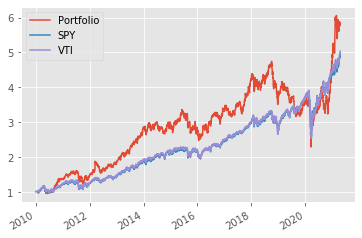

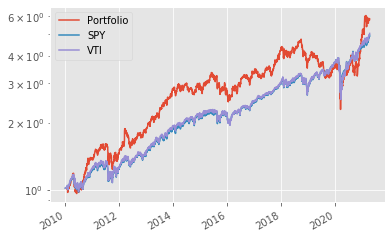

In [60]:
Nt    = 20       #number of top performing stocks to select.  This is a random choice.  I could experiment with this
Nb    = 20       #number of bottom performing stocks to select. This is a random choice.  I could experiment with this

CUT_HIGH   = 5   #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"
CUT_LOW    = 10  #this is the number of stocks to cut off the top/bottom of the momentum/mean-reversion stocks to avoid too much of "buying the hype" or "catching a falling knife"

KEEP_HIGH = max(Nt - CUT_HIGH, 0)  #I don't want anything to break, so setting a minimum of zero here
KEEP_LOW  = max(Nb - CUT_LOW, 0)   #I don't want anything to break, so setting a minimum of zero here

FREQ  = 'M'   #this is the frequency at which to resample the data for which to compare averages.  Only use A, Q, M, or W strings.   
MIN_WEIGHT = 0.005  #minimum stock weight, if choosing the cvoptx select_weights function

MIN_P = 20         #minimum price requirement
MIN_V = 1000000    #minimum dollar volume requirement

#BE SURE TO VERIFY THE GLOBAL VARIABLES ABOVE BEFORE RUNNING THE BACKEST
#CHOOSE 2009-09-03 AS THE EARLIEST START DATE IN ORDER TO ENSURE ~100 TRADING DAYS AVAILABLE TO CALCULATE COVARIANCE IN select_weights FUNCTION, IF USING cvoptx

portfolio, weights, trades = run_backtest('month', '2010-1-1') # MAKE SURE FREQ ABOVE MATCHES THE FREQUENCY CALLED IN THE BACKTEST

t = portfolio.to_frame('Portfolio').join(benchmark.pct_change())

compare_performance(t)

In [61]:
t.add(1).cumprod()

,Portfolio,SPY,VTI
2010-01-04,NaN,1.016960,1.016676
2010-02-01,1.006218,1.032774,1.032199
2010-02-02,1.016086,1.045274,1.045478
2010-02-03,1.006492,1.040066,1.040241
2010-02-04,0.976089,1.007964,1.007885
...,...,...,...
2021-04-12,5.767766,4.868656,4.966240
2021-04-13,5.776897,4.883086,4.980151
2021-04-14,5.790358,4.866409,4.969022
2021-04-15,5.837658,4.918686,5.021884


I WIN!

### Analysis

This strategy seems like it works!  At very least, for the time period considered, it 'beat' the market from a returns standpoint.  From a Risk Premium, Volatility, and Sharpe Ratio perspective, this strategy trailed the market.  That's not really that surprising, since it trades on stocks that are performing most divergently from their historical average (basically the definition of volatilty). Up until shortly after 2018, this strategy seemed to greatly outperform the SPY/VTI benchmarks.  I'm not sure exactly why 2018 seemed to be when this strategy "came back to Earth" or what it was in the early 2010's that resulted in the superior performance.  As mentioned, this strategy is inherently risky as it trades on recent bias (monthly, in this specific analysis) for over- and under-performing stocks.  This is akin to a "timing the market" strategy, which has been repeatedly been shown to underperform in the long-term. However, the results of this particular analysis are promising, but not indicitive of long-term success.

### Conclusion

It seems that in high-growth, strong market conditions (last 10 years), this strategy will perform well.  Obviously, "a rising tide that lifts all boats" bodes well for both high momentum stocks (building on current success) and under-performing stocks (being lifted by general strong-market sentiment).  However, as can be seen from post-2018 until the COVID pandemic, this strategy tanked considerably relative to benchmark indices.  And then, post-COVID, the strategy has done exceedingly well.  Quite a roller-coaster!  It seems to provide some wisdom against the highly volatile, "chasing earnings," or "buy-the dip" strategies, at least when things go South. I think there's some potential to fine-tune some of the variables in this strategy and optimizing, but, ultimately, I don't expect that I've found anything earth-shattering in my "MOMENTUM + MEAN REVERSION COMBO STRATEGY."

This was such a fun class.  I wish I would've started my finaly project earlier, but I still enjoyed it...Thanks, Jan!